In [13]:
! pip install git+https://github.com/karolzak/keras-unet
# ! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/karolzak/keras-unet to c:\users\hazard\appdata\local\temp\pip-req-build-k08afn50
  Created wheel for keras-unet: filename=keras_unet-0.1.2-py3-none-any.whl size=17139 sha256=3e1b38c30c047356a6b4bc5a2a1adccb06d9a8b957d5834e37bfaab5b010ad89
  Stored in directory: C:\Users\Hazard\AppData\Local\Temp\pip-ephem-wheel-cache-l3vtxrs8\wheels\df\f6\e3\829702eaa69ce1a9a8db64c6f49e2b7f2bd5ef8e534ba08070
Successfully built keras-unet


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In the directory "raw", there exists more images that there are pairs with masks. We realize that there is a difference between the images which names start with TXXXH and TXXXO. The TXXXH seemingly contain more noise than the TXXXO, so we could assume that those are preprocessed by denoising in some way.

We preprocess all the images and downsize them from 1400x1400 to 400x400, also convert the images to grayscale.

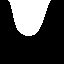

In [1]:
import os, re
from PIL import Image
from IPython.display import Image as Img, display

img_size = 64, 64
input_pattern = re.compile("T[0-9]{3}O_crop_[0-9].png")
input_dir = "raw/"
target_pattern = re.compile("T[0-9]{3}OM_crop_[0-9].png")
target_dir = "mask/"

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if target_pattern.match(fname)
    ]
)
input_img_paths = [""]
input_img_paths.remove("") # for autocomplete
for fname in target_img_paths:
  fname = fname.replace("M", "").replace("mask/", "raw/")
  if os.path.isfile(fname):
    input_img_paths.append(fname)
  else:
    print("Bad input file: ", fname)

if not os.path.exists("target"):
    os.mkdir("target")
for infile in target_img_paths:
    outfile = infile.replace("mask/", "target/")
    if infile != outfile:
        try:
            im = Image.open(infile)
            # Downscale without smoothing/antialiasing with NEAREST alg
            # to get exactly either 0 or 255 pixel value
            im.thumbnail(img_size, Image.NEAREST)
            im.save(outfile, "PNG")
        except IOError:
            print("cannot create thumbnail for '%s'" % infile)

# Show example of produced downscaled image
display(Img(filename=target_img_paths[9].replace("mask/", "target/")))

if not os.path.exists("input"):
    os.mkdir("input")
for infile in input_img_paths:
    outfile = infile.replace("raw/", "input/")
    if infile != outfile:
        try:
            im = Image.open(infile)
            
            # to grayscale
            # im = im.convert('L')

            im.thumbnail(img_size)
            im.save(outfile, "PNG")
        except IOError:
            print("cannot create thumbnail for '%s'" % infile)

We read all the files based on the existance of its accompanying masked equivalent.

In [2]:
import os

input_dir = "input/"
target_dir = "target/"

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
    ]
)
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ]
)

print("Number of samples:", len(input_img_paths), len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 153 153
input/T001O_crop_0.png | target/T001OM_crop_0.png
input/T001O_crop_1.png | target/T001OM_crop_1.png
input/T002O_crop_2.png | target/T002OM_crop_2.png
input/T002O_crop_3.png | target/T002OM_crop_3.png
input/T002O_crop_4.png | target/T002OM_crop_4.png
input/T003O_crop_1.png | target/T003OM_crop_1.png
input/T003O_crop_2.png | target/T003OM_crop_2.png
input/T003O_crop_3.png | target/T003OM_crop_3.png
input/T003O_crop_4.png | target/T003OM_crop_4.png
input/T004O_crop_1.png | target/T004OM_crop_1.png


We evaluate whether the raw image is matched with the correct mask image.

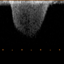

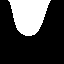

In [7]:
from IPython.display import Image, display
from keras.preprocessing.image import load_img
from PIL import ImageOps
import numpy as np

# Display input image #9
raw = load_img(input_img_paths[9])
display(raw)

# Display auto-contrast version of corresponding target (per-pixel categories)
# mask = load_img(path, target_size=self.img_size, color_mode="grayscale")
mask = load_img(target_img_paths[9])
display(ImageOps.autocontrast(mask))


Epoch 1/4
8/8 [==============================] - ETA: 0s - loss: 332.4624 - accuracy: 0.0653

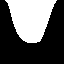

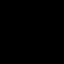


Sample Prediction after binary_crossentropy rmsprop epoch 1

8/8 [==============================] - 23s 3s/step - loss: 332.4624 - accuracy: 0.0653
Epoch 2/4
8/8 [==============================] - ETA: 0s - loss: 2.5124 - accuracy: 0.0653

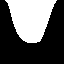

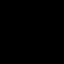


Sample Prediction after binary_crossentropy rmsprop epoch 2

8/8 [==============================] - 21s 3s/step - loss: 2.5124 - accuracy: 0.0653
Epoch 3/4
6/8 [=====================>........] - ETA: 5s - loss: 1.4940 - accuracy: 0.0460

KeyboardInterrupt: 

In [44]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import load_img

class TrainSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 channels (rgb)
        input = np.zeros((self.batch_size, self.img_size[0], self.img_size[1], 3), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            # img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            img = load_img(path, target_size=self.img_size)
            img_arr = np.array(img)
            # img_arr = np.expand_dims(img_arr, axis=-1)
            input[j] = img_arr

        # 3 channels (rgb)
        target = np.zeros((self.batch_size, self.img_size[0], self.img_size[1], 1), dtype='float32')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            # img = load_img(path, target_size=self.img_size)
            img_arr = np.array(img)
            for img_x, row in enumerate(img_arr):
              for img_y, pixel in enumerate(row):
                img_arr[img_x][img_y] = 1 if (pixel == 255) else 0
            img_arr = np.expand_dims(img_arr, axis=-1)
            target[j] = img_arr

        return input, target



import random

# Split our img paths into a training and a validation set
val_samples = 30
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
num_classes = 2
batch_size = 14 # we get 13 in the last batch, good (153 mod 14 = 13)
# see https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
train_gen = TrainSequence(
    batch_size, 
    img_size, 
    train_input_img_paths,
    val_target_img_paths)

import tensorflow as tf
from keras.preprocessing.image import load_img
from IPython.display import Image, display
from PIL import ImageOps

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

epochs = 4

class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self, model, loss, optimizer):
    self.model = model
    self.loss = loss
    self.optimizer = optimizer
  
  def on_epoch_end(self, epoch, logs=None):
    pred_mask = self.model.predict(TrainSequence(1, img_size, [input_img_paths[9]], [target_img_paths[9]]))[0]
    # pred_mask = np.argmax(pred_mask, axis=-1)
    # pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = keras.preprocessing.image.array_to_img(pred_mask)
    # display(load_img(input_img_paths[9]))
    display(load_img(target_img_paths[9]))
    display(pred_mask)
    print(f'\nSample Prediction after {self.loss} {self.optimizer} epoch {epoch+1}\n')

import segmentation_models as sm

def train(loss, optimizer):
  keras.backend.clear_session()

  model = sm.Unet(
    'resnet34', classes=1, activation='sigmoid', encoder_weights=None)

  callbacks = [DisplayCallback(model, loss, optimizer)]
  
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  model.fit(train_gen, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

train("binary_crossentropy", "rmsprop")
# train("binary_crossentropy", "adam")
# train("sparse_categorical_crossentropy", "rmsprop")
# train("sparse_categorical_crossentropy", "adam")
# train("categorical_crossentropy", "rmsprop")
# train("categorical_crossentropy", "adam")